In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import xarray as xr
from pyrealm.pmodel import PModel, PModelEnvironment
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter
from pyrealm.pmodel import PModel, PModelEnvironment, SubdailyScaler, SubdailyPModel
from pyrealm.pmodel.functions import calc_ftemp_arrh, calc_ftemp_kphio
from pyrealm.pmodel.subdaily import memory_effect
from pyrealm.pmodel.optimal_chi import OptimalChiPrentice14


def pModel_subdaily(
    datetime_subdaily_df: pd.DataFrame,
    temp_subdaily: pd.DataFrame,
    ppfd_subdaily: pd.DataFrame,
    vpd_subdaily: pd.DataFrame,
    co2_subdaily: pd.DataFrame,
    patm_subdaily: pd.DataFrame,
    fpar_subdaily: pd.DataFrame,
    days_memory: float,
    window_center_i: int,
    half_width_i: int,
):

    # # Extract the key half hourly timestep variables as numpy arrays
    # temp_subdaily = df_site_and_modis.loc[
    #     :, "TA_F"
    # ]  # daily temperature, unit degree (°C)
    # ppfd_subdaily = df_site_and_modis.loc[:, "PPFD_IN"]
    # vpd_subdaily = (
    #     df_site_and_modis.loc[:, "VPD_F"] * 100
    # )  # vpd, unit: hPa converted to Pa
    # co2_subdaily = df_site_and_modis.loc[:, "CO2_F_MDS"]  # CO2, unit ppm
    # patm_subdaily = (
    #     df_site_and_modis.loc[:, "PA_F"] * 1000
    # )  # site pressure, unit kPa converted to Pa
    # # rename column starting with 'Fpar_500m_(some Date)' to 'Fpar_500m'
    # df_site_and_modis.columns = df_site_and_modis.columns.str.replace(
    #     r"Fpar_500m_\d{4}-\d{2}-\d{2}", "Fpar_500m", regex=True
    # )
    # fpar_subdaily = (
    #     df_site_and_modis.loc[:, "Fpar_500m"] * 100
    # )  # 100 to convert to percent

    temp_subdaily.loc[temp_subdaily < -25, "TA_F"] = np.nan
    vpd_subdaily.values[vpd_subdaily.values < 0] = 0
    ppfd_subdaily.values[ppfd_subdaily.values < 0] = 0
    co2_subdaily.values[co2_subdaily.values < 0] = 0

    # Calculate the photosynthetic environment
    subdaily_env = PModelEnvironment(
        tc=temp_subdaily.values,
        vpd=vpd_subdaily.values,
        co2=co2_subdaily.values,
        patm=patm_subdaily.values,
    )

    # Create the fast slow scaler
    datetime_subdaily = pd.to_datetime(datetime_subdaily_df).to_numpy()
    fsscaler = SubdailyScaler(datetime_subdaily)

    # Set the acclimation window as the values within a one hour window centred on noon
    fsscaler.set_window(
        window_center=np.timedelta64(window_center_i, "h"),
        half_width=np.timedelta64(half_width_i, "m"),
    )

    # Fit the P Model with fast and slow responses
    pmodel_subdaily = SubdailyPModel(
        env=subdaily_env,
        fs_scaler=fsscaler,
        allow_holdover=True,
        ppfd=ppfd_subdaily.values,
        fapar=fpar_subdaily.values,
    )

    temp_acclim = fsscaler.get_daily_means(temp_subdaily.values)
    co2_acclim = fsscaler.get_daily_means(co2_subdaily.values)
    vpd_acclim = fsscaler.get_daily_means(vpd_subdaily.values)
    patm_acclim = fsscaler.get_daily_means(patm_subdaily.values)
    ppfd_acclim = fsscaler.get_daily_means(ppfd_subdaily.values)
    fapar_acclim = fsscaler.get_daily_means(fpar_subdaily.values)

    # Fit the P Model to the acclimation conditions
    daily_acclim_env = PModelEnvironment(
        tc=temp_acclim, vpd=vpd_acclim, co2=co2_acclim, patm=patm_acclim
    )

    pmodel_acclim = PModel(daily_acclim_env, kphio=1 / 8)
    pmodel_acclim.estimate_productivity(fapar=fapar_acclim, ppfd=ppfd_acclim)
    # pmodel_acclim.summarize()

    ha_vcmax25 = 65330
    ha_jmax25 = 43900
    tk_acclim = temp_acclim + pmodel_subdaily.env.core_const.k_CtoK
    vcmax25_acclim = pmodel_acclim.vcmax * (1 / calc_ftemp_arrh(tk_acclim, ha_vcmax25))
    jmax25_acclim = pmodel_acclim.jmax * (1 / calc_ftemp_arrh(tk_acclim, ha_jmax25))
    # Calculation of memory effect in xi, vcmax25 and jmax25
    xi_real = memory_effect(pmodel_acclim.optchi.xi, alpha=1 / days_memory)
    vcmax25_real = memory_effect(
        vcmax25_acclim, alpha=1 / days_memory, allow_holdover=True
    )
    jmax25_real = memory_effect(
        jmax25_acclim, alpha=1 / days_memory, allow_holdover=True
    )
    tk_subdaily = subdaily_env.tc + pmodel_subdaily.env.core_const.k_CtoK

    # Fill the realised jmax and vcmax from subdaily to daily
    vcmax25_subdaily = fsscaler.fill_daily_to_subdaily(vcmax25_real)
    jmax25_subdaily = fsscaler.fill_daily_to_subdaily(jmax25_real)

    # Adjust to actual temperature at subdaily timescale
    vcmax_subdaily = vcmax25_subdaily * calc_ftemp_arrh(tk=tk_subdaily, ha=ha_vcmax25)
    jmax_subdaily = jmax25_subdaily * calc_ftemp_arrh(tk=tk_subdaily, ha=ha_jmax25)

    # Interpolate xi to subdaily scale
    xi_subdaily = fsscaler.fill_daily_to_subdaily(xi_real)

    # Calculate the optimal chi, imposing the realised xi values
    subdaily_chi = OptimalChiPrentice14(env=subdaily_env)
    subdaily_chi.estimate_chi(xi_values=xi_subdaily)

    # Calculate Ac
    Ac_subdaily = (
        vcmax_subdaily
        * (subdaily_chi.ci - subdaily_env.gammastar)
        / (subdaily_chi.ci + subdaily_env.kmm)
    )

    # Calculate J and Aj
    phi = (1 / 8) * calc_ftemp_kphio(tc=temp_subdaily)
    iabs = fpar_subdaily * ppfd_subdaily

    J_subdaily = (4 * phi * iabs) / np.sqrt(1 + ((4 * phi * iabs) / jmax_subdaily) ** 2)

    Aj_subdaily = (
        (J_subdaily / 4)
        * (subdaily_chi.ci - subdaily_env.gammastar)
        / (subdaily_chi.ci + 2 * subdaily_env.gammastar)
    )

    # Calculate GPP and convert from micromols to micrograms
    GPP_subdaily = (
        np.minimum(Ac_subdaily, Aj_subdaily)
        * pmodel_subdaily.env.core_const.k_c_molmass
    )

    gC_to_mumol = 0.0833  # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹
    GPP_subdaily *= gC_to_mumol
    # print(
    #     f"GPPmean {np.nanmean(GPP_subdaily)} at {days_memory} days_mem at {window_center_i}h {half_width_i}m"
    # )

    return GPP_subdaily  # ,datetime_subdaily


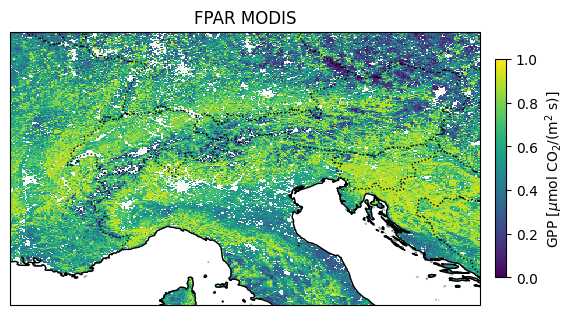

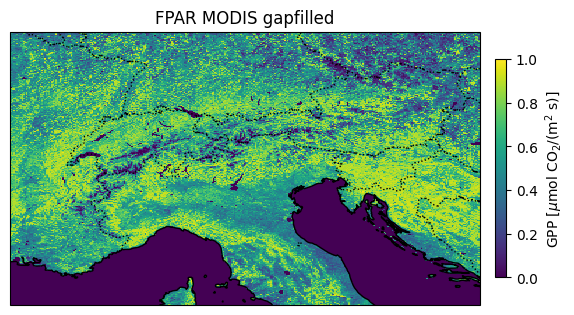

In [3]:

# Load WRF dataset
# wrf_paths
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20250107_155336_ALPS_3km",
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20250105_193347_ALPS_9km",
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_112716_ALPS_27km",
# "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241227_183215_ALPS_54km",
day = 15
wrf_path = f"/scratch/c7071034/DATA/WRFOUT/WRFOUT_20250107_155336_ALPS_3km/wrfout_d01_2012-07-{day:02d}_12:00:00"
wrf_ds = xr.open_dataset(wrf_path)
days_memory = 14
window_center_i = 13
half_width_i = 90

# Load variables from WRF dataset 
temp = wrf_ds["T2"].to_numpy() - 273.15  # Convert to Celsius
patm = wrf_ds["PSFC"].to_numpy()  # Pa
co2 = wrf_ds["CO2_BIO"].isel(bottom_top=0).to_numpy()  # ppmv
qvapor = wrf_ds["QVAPOR"].isel(bottom_top=0).to_numpy()  # Water vapor mixing ratio (kg/kg) at the surface level
psfc = wrf_ds["PSFC"].isel(Time=0).to_numpy()            # Surface pressure (Pa)
t2 = wrf_ds["T2"].isel(Time=0).to_numpy()                # Temperature at 2m (K)

# Calculate actual vapor pressure (ea) in kPa
ea = (qvapor * psfc) / (0.622 + qvapor)  # Pa 
# Calculate saturation vapor pressure (es) in kPa
es = 0.6108 * np.exp((17.27 * temp) / (temp + 237.3)) * 1000 # convert to Pa
# Calculate VPD
vpd = np.maximum(0, es - ea)  # Force non-negative VPD


# Load required variables from WRF dataset
vegfra = wrf_ds["VEGFRA"].to_numpy()   # Vegetation fraction (0 to 1)
albedo = wrf_ds["ALBEDO"].to_numpy()   # Albedo (0 to 1)
swdown = wrf_ds["SWDOWN"].to_numpy()   # Downward shortwave radiation (W/m^2)
ppfd = swdown * 2.30785 # Shortwave radiation (W/m²) × 0.505 -> PAR (W/m²) × 4.57 -> 2.3*x ~ PPFD (umol/m²/s)
xlat = wrf_ds["XLAT"].to_numpy()       # Latitude (degrees)
xlon = wrf_ds["XLONG"].to_numpy()      # Longitude (degrees)
xlat = xlat[0, :,:]
xlon = xlon[0, :,:]
fapar_wrf = (1 - albedo) * (vegfra/100) # Calculate fAPAR

# get modis fpar
modis_path = f"/scratch/c7071034/DATA/MODIS/MODIS_FPAR/fpar_interpol/interpolated_fpar_3km_2012-07-{day:02d}T12:00:00.nc"
modis_ds = xr.open_dataset(modis_path)
fpar_modis = modis_ds["Fpar_500m"].to_numpy()  # fAPAR from MODIS

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=1)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fpar_modis[0, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("FPAR MODIS")
plt.show()

# where modis is nan use values from fapar_wrf
fpar_modis_gapfilled = np.where(np.isnan(fpar_modis), fapar_wrf, fpar_modis) # TODO: how is this handled in literature? There is no fPAR Data around cities, so these areas could also be masked out, but I would habe to modify the landcover maps... 

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=1)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fpar_modis_gapfilled[0, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("FPAR MODIS gapfilled")
plt.show()



In [4]:

# Ensure proper dimensions and clean invalid data
temp[temp < -25] = np.nan  # Mask temperatures below -25°C
vpd = np.clip(vpd, 0, np.inf)  # Force VPD ≥ 0

# Run P-model environment
env = PModelEnvironment(tc=temp, co2=co2, patm=patm, vpd=vpd)
env.summarize()

# Estimate productivity
model = PModel(env)
model.estimate_productivity(fpar_modis_gapfilled, ppfd)

gC_to_mumol = 0.0833 # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹
gpp_pmodel = model.gpp[0, :, :] * gC_to_mumol

STD_TOPO = 50 # Standard deviation threshold for topography
stdh_topo_3km = wrf_ds["VAR"].to_numpy()    # Standard deviation of the subgrdscale topography
land_mask = wrf_ds["LANDMASK"].to_numpy()  # Landmask (1 = land, 0 = water)
hgt = wrf_ds["HGT"].to_numpy()  # Terrain height
stdh_mask = stdh_topo_3km < STD_TOPO
mask = land_mask * stdh_mask
gpp_pmodel = np.where(mask, np.nan, gpp_pmodel)
hgt = np.where(mask, np.nan, hgt)

# pModel_subdaily(
#     datetime_subdaily_df=modis_ds["time"],
#     temp_subdaily=temp,
#     ppfd_subdaily=ppfd,
#     vpd_subdaily=vpd,
#     co2_subdaily=co2,
#     patm_subdaily=patm,
#     fpar_subdaily=fpar_modis_gapfilled,
#     days_memory=days_memory,
#     window_center_i=window_center_i,
#     half_width_i=half_width_i,
# )


PModelEnvironment(shape=(1, 284, 338))
Attr           Mean       Min        Max    NaN  Units
---------  --------  --------  ---------  -----  -------
tc            19.66     -5.4       35.32      0  °C
vpd         1111.56      0       4461.88      0  Pa
co2          388.43    356.26     406.59      0  ppm
patm       95477.6   64038     101997         0  Pa
ca            37.09     24.96      41.03      0  Pa
gammastar      3.28      0.49       7.13      0  Pa
kmm           50.25      3.82     171.02      0  Pa
ns_star        1.16      0.8        2.46      0  -


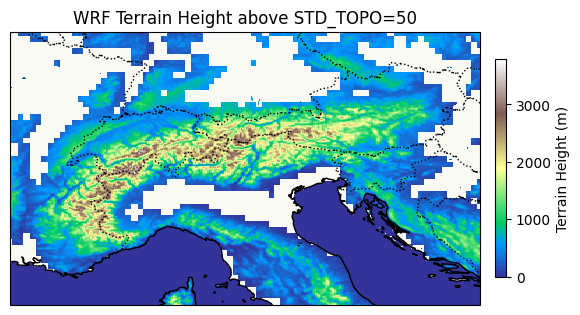

In [5]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

# Use the 'terrain' colormap
terrain_cmap = plt.cm.terrain
terrain_norm = mcolors.Normalize(vmin=np.nanmin(hgt), vmax=np.nanmax(hgt))

mesh = ax.pcolormesh(xlon, xlat, hgt[0,:,:], cmap=terrain_cmap, norm=terrain_norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label('Terrain Height (m)')
plt.title(f"WRF Terrain Height above STD_TOPO={STD_TOPO}")
plt.show()


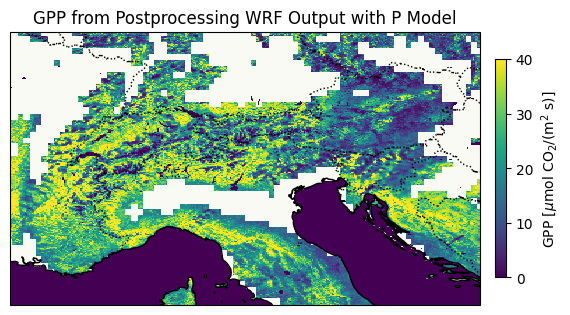

In [6]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=40)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, gpp_pmodel[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("GPP from Postprocessing WRF Output with P Model")
plt.show()


In [7]:
wrf_gpp = wrf_ds["EBIO_GEE"].isel(Time=0).to_numpy() 
wrf_gpp *= -1/3600 # mol km-2 h-1 -> mircro mol m-2 s-1
def nanmean_filter(values):
    return np.nanmean(values)
# wrf_gpp_filtered = generic_filter(wrf_gpp, nanmean_filter, size=3, mode='constant', cval=np.nan)
wrf_gpp_filtered = wrf_gpp
wrf_gpp_filtered = np.where(np.isnan(wrf_gpp), wrf_gpp_filtered, wrf_gpp)
wrf_gpp_filtered = np.where(mask, np.nan, wrf_gpp_filtered)

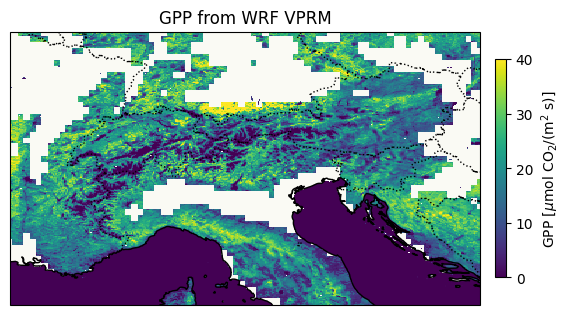

In [8]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=40)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, wrf_gpp_filtered[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("GPP from WRF VPRM")
plt.show()


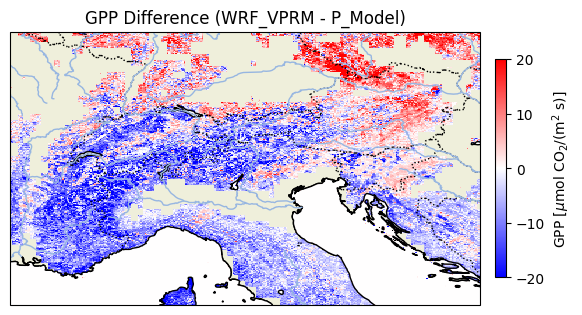

In [9]:
# Assuming wrf_gpp, model.gpp, gC_to_mumol, xlon, xlat are defined earlier
gpp_diff = wrf_gpp_filtered - gpp_pmodel

# Create a map with a PlateCarree projection (a simple lat/lon projection)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)
vmin, vmax = -20, 20
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.bwr
mesh = ax.pcolormesh(xlon, xlat, gpp_diff[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
ax.set_title("GPP Difference (WRF_VPRM - P_Model)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show plot
plt.show()
